## **Important** **packages**

In [ ]:
!pip install minisom
!pip install sklearn-som

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for minisom: filename=MiniSom-2.3.0-py3-none-any.whl size=9018 sha256=c4300d8c3f3f2a4466eacc6153781bed95efff9335f492348b2947f4b40dc48b
  Stored in directory: /root/.cache/pip/wheels/d4/ca/4a/488772b0399fec45ff53132ed14c948dec4b30deee3a532f80
Successfully built minisom
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Import important packages 
import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,plot_confusion_matrix,classification_report
from sklearn.feature_selection import mutual_info_classif, VarianceThreshold
from sklearn.feature_selection import SelectKBest
from tqdm import tqdm
from sklearn.cluster import DBSCAN
from sklearn.utils.multiclass import unique_labels
from minisom import MiniSom
from sklearn_som.som import SOM
from sklearn.metrics import silhouette_score
from minisom import MiniSom
import itertools
%matplotlib inline

## **Functions**

In [ ]:
#ploting confusion matrix
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay

def con_matrix(model,actual ,predict , title): 
  cm = confusion_matrix(actual, predict)
  cm_display = ConfusionMatrixDisplay(cm,display_labels=model.classes_ , ).plot(cmap=plt.cm.Reds)
  plt.title(title)
  plt.show()
  return cm_display

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def k_mean (k_start , k_end ,data , figsize1 = 15 , figsize2 = 6 ) :
  #k_mean 
  max_silhouette = 0
  distortions = []
  s = []
  for k in range(k_start,k_end):
      kmeanModel = KMeans(n_clusters=k, random_state = 0)
      kmean = kmeanModel.fit_predict(data)
      distortions.append(kmeanModel.inertia_)
      # Calculate Silhoutte Score 
  for k in range(k_start + 1 ,k_end):
      kmeanModel = KMeans(n_clusters=k, random_state = 0)
      kmean = kmeanModel.fit_predict(data)
      score = silhouette_score(data, kmeanModel.labels_, metric='euclidean')
      s.append(score)
      if max_silhouette < score:
            max_silhouette = score 
            best_k = k
       

  #ploting
  fig, axes = plt.subplots(1, 2, figsize=(figsize1,figsize2))
  #k_mean plot
  axes[0].plot(range(k_start,k_end), distortions, 'rx-')
  axes[0].set(xlabel='Number of clusters', ylabel='Distortion')
  axes[0].set_title('Elbow Method(k-means)')
  #silhouette plot
  axes[1].plot(range(k_start +1, k_end), s, 'rx-')
  axes[1].set(xlabel='Number of clusters')
  axes[1].set_title('silhouette')
  print('optimal number of clusters is : {} clusters'.format(best_k))
  print('Silhouetter Score: %.3f' % max_silhouette)
  return best_k , max_silhouette

In [ ]:
def Visulaize_Data(X,Labels ,Title):  
    from sklearn.manifold import TSNE
    tfs_embedded = TSNE(n_components=2, perplexity=50, verbose=2 , random_state=1 , n_iter=2000).fit_transform(X)
    sns.set_theme(style="white")
    sns.scatterplot(x=tfs_embedded[:, 0], y=tfs_embedded[:, 1],hue=Labels,palette = ['black','red'], legend='full')
    plt.xlabel('component1')
    plt.ylabel('component2')
    plt.title(Title)
    plt.show()

In [ ]:
def features_accurcy (accuracies,title, range1,range2) :
  print("Best number of features:", np.argmax(accuracies)+1)
  print("Best accurcy :",max(accuracies))
  sns.set_theme(style="whitegrid")
  bar = sns.barplot(x=[n for n in range(range1,range2)],y= accuracies , color='maroon')
  patch_h = [patch.get_height() for patch in bar.patches]   
  idx_tallest = np.argmax(patch_h)
  bar.patches[idx_tallest].set_facecolor('black')  
  plt.ylabel("Accurcy", fontsize = 15)
  plt.xlabel("# Features", fontsize = 15)
  plt.title(title, fontsize = 20)
  plt.show()

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
def wrapper (range1,range2,model,modelacc,direction, xtrain,ytrain,xtest,ytest):
  accur=[]
  for n in range(range1,range2):
    sfs=SequentialFeatureSelector(estimator=KNeighborsClassifier(),n_features_to_select=n, direction= direction)
    X_train_new=sfs.fit_transform(xtrain,ytrain)
    X_test_new=sfs.transform(xtest)

    model_sfs = model.fit(X_train_new,ytrain)
    y_pred_sfs = model_sfs.predict(X_test_new)
    accur.append(accuracy_score(ytest,y_pred_sfs))
  accur.append(modelacc)
  return accur

In [ ]:
def select_feature(X_train, y_train, X_test, y_test, FSM, model):
  fs = FSM
  fs.fit(X_train, y_train)
  X_train_new = fs.transform(X_train)
  X_test_new = fs.transform(X_test) 
  model.fit(X_train_new, y_train)
  y_pred = model.predict(X_test_new)
  acc = accuracy_score(y_test, y_pred) * 100
  
  return acc,X_train_new,X_test_new

In [ ]:
def Sooom(ft):
  silscore_list=[]
  ncList=[]
  max_silhouette=0
  optimal_neuron=0
  max_score=0

  #shape the data
  _ , dim=ft.shape


  max_neurons= range(2,30)
  for i in max_neurons:
      som= SOM(m=i,n=1,dim=dim)
      cls= som.fit_predict(ft)
      score = silhouette_score(ft, cls, random_state=0)
      silscore_list.append(score)
      ncList.append(i)
      if max_score < score:
            max_score = score 
            optimal_neuron = i
  

  #plot number of neurons Vs  silhouette score

  plt.plot(max_neurons,silscore_list ,c = 'r')
  plt.xlabel("number of neurons")
  plt.ylabel("Silhouette score ")
  plt.show
  print('Optimal number of neurons is : {}'.format(optimal_neuron))
  print('The silhouette score is : {}'.format(max_score))
  return optimal_neuron,max_score


In [ ]:
def plot_state(state,data):
  plt.subplots(figsize=(10, 6))
  colors = itertools.cycle(["red", "black"])
  # plotting the clusters using the first 2 dimentions of the data
  for c in np.unique(cluster_index):
      plt.scatter(data[cluster_index == c, 0],
                  data[cluster_index == c, 1], label='cluster='+str(c), alpha=.7, color=next(colors))

  # plotting centroids
  plt.scatter(state[:, 0], state[:, 1], marker='o', 
                  s=8, linewidths=10, color='darkblue', label='neuron')
  plt.legend()
  plt.xlabel("component1")
  plt.ylabel("component2")
  plt.show()

## **Read Data**

In [ ]:
#Load the MCSDataset
!gdown --id 1Ln2wfZ1U6OZ_oDcLscc1YZxzUrHivC3j


/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Ln2wfZ1U6OZ_oDcLscc1YZxzUrHivC3j
To: /content/Assignment3_dataset.csv
100% 65.8k/65.8k [00:00<00:00, 57.8MB/s]
/bin/bash: gdoun: command not found


In [ ]:
!gdown --id 1OAPwYiJ9zel4qDKRP4F31C6cj_uf8Sr2

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1OAPwYiJ9zel4qDKRP4F31C6cj_uf8Sr2
To: /content/Assignment3_dataset.csv
100% 65.8k/65.8k [00:00<00:00, 27.8MB/s]


In [ ]:
df= pd.read_csv('/content/Assignment3_dataset.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.411765,0.623116,0.573770,0.333333,0.254137,0.380030,0.035440,0.266667,0
1,0.294118,0.542714,0.590164,0.434343,0.088652,0.538003,0.078992,0.200000,0
2,0.058824,0.437186,0.491803,0.373737,0.088652,0.554396,0.184031,0.016667,0
3,0.058824,0.723618,0.672131,0.464646,0.212766,0.687034,0.109735,0.416667,1
4,0.058824,0.557789,0.508197,0.131313,0.215130,0.357675,0.025619,0.033333,0


In [ ]:
x = df.iloc[:,:-1]
y = df.iloc[:,-1]

#split the training data into train set and test set
train_set = df.iloc[0:576,:]
test_set = df.iloc[576:,:]
#split the training data into xtrain and ytrain
X_train = train_set.drop('Outcome',axis=1)
y_train = train_set['Outcome']
#split the training data into xtest and ytest
X_test = test_set.drop('Outcome',axis=1)
y_test = test_set['Outcome']

print('Training set length: {} Row'.format(len(X_train)))
print('Testing set length: {} Row'.format(len(X_test)))

Training set length: 576 Row
Testing set length: 192 Row


In [ ]:
from sklearn.manifold import TSNE
tfs_embedded1 = TSNE(n_components=2, perplexity=50, verbose=2 , random_state=1 , n_iter=2000).fit_transform(X_train , y_train)
tfs_embedded2 = TSNE(n_components=2, perplexity=50, verbose=2 , random_state=1 , n_iter=2000).fit_transform(X_test,y_test)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 576 samples in 0.001s...
[t-SNE] Computed neighbors for 576 samples in 0.044s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed conditional probabilities for sample 576 / 576
[t-SNE] Mean sigma: 0.161118
[t-SNE] Computed conditional probabilities in 0.163s
[t-SNE] Iteration 50: error = 63.5027351, gradient norm = 0.4519499 (50 iterations in 1.784s)
[t-SNE] Iteration 100: error = 63.6532478, gradient norm = 0.4531353 (50 iterations in 1.328s)
[t-SNE] Iteration 150: error = 63.6789780, gradient norm = 0.4458083 (50 iterations in 1.264s)
[t-SNE] Iteration 200: error = 63.6663971, gradient norm = 0.4488887 (50 iterations in 1.801s)
[t-SNE] Iteration 250: error = 63.3619766, gradient norm = 0.4445145 (50 iterations in 1.263s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.361977
[t-SNE] Iteration 300: error = 0.9115279, gradient norm = 0.0023851 (50 iterations in 1.859s)
[t-SNE] Iteration 350: error = 0.8454173, gradient norm = 0.0004870 (50 iterations in 0.967s)
[t-SNE] Iteration 400: error = 0.8327268, gradient norm = 0.0004015 (50 iterations in 0.960s)
[t-SNE] Iteration 45

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Iteration 50: error = 57.2474899, gradient norm = 0.5072863 (50 iterations in 0.186s)
[t-SNE] Iteration 100: error = 54.1762924, gradient norm = 0.4882887 (50 iterations in 0.158s)
[t-SNE] Iteration 150: error = 56.9599495, gradient norm = 0.4829982 (50 iterations in 0.221s)
[t-SNE] Iteration 200: error = 55.6255112, gradient norm = 0.5170461 (50 iterations in 0.259s)
[t-SNE] Iteration 250: error = 54.9378204, gradient norm = 0.5211888 (50 iterations in 0.172s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.937820
[t-SNE] Iteration 300: error = 0.6156696, gradient norm = 0.0074679 (50 iterations in 0.149s)
[t-SNE] Iteration 350: error = 0.4586270, gradient norm = 0.0041479 (50 iterations in 0.207s)
[t-SNE] Iteration 400: error = 0.4280060, gradient norm = 0.0022364 (50 iterations in 0.324s)
[t-SNE] Iteration 450: error = 0.3829363, gradient norm = 0.0015855 (50 iterations in 0.230s)
[t-SNE] Iteration 500: error = 0.3759347, gradient norm = 0.0002957 (50 

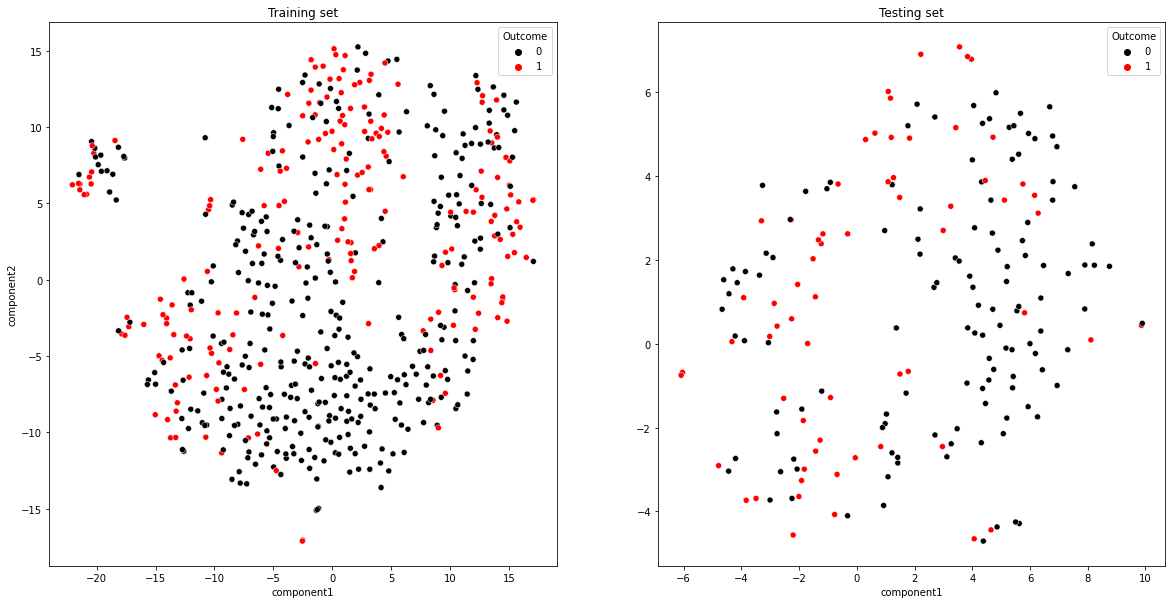

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
axes[0].set_title('Training set')
axes[1].set_title('Testing set')
sns.scatterplot(ax=axes[0],x=tfs_embedded1[:, 0], y=tfs_embedded1[:, 1] ,hue = y_train,palette = ['black','red'], legend='full')
sns.scatterplot(ax=axes[1],x=tfs_embedded2[:, 0], y=tfs_embedded2[:, 1],hue = y_test,palette = ['black','red'], legend='full')
axes[0].set(xlabel='component1', ylabel='component2')
axes[1].set(xlabel='component1')
plt.show()

## **LR classifier**

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train)
lr_pre = lr.predict(X_test)
lr_pre_train = lr.predict(X_train)
lr_acc = accuracy_score(y_test, lr_pre)

print('testing accuracy of Logistic Regression Classifier: {} %'.format(lr_acc * 100))
print(classification_report(y_test,lr_pre))

testing accuracy of Logistic Regression Classifier: 77.08333333333334 %
              precision    recall  f1-score   support

           0       0.77      0.92      0.84       127
           1       0.76      0.48      0.58        65

    accuracy                           0.77       192
   macro avg       0.77      0.70      0.71       192
weighted avg       0.77      0.77      0.75       192



## **K-NN classifier**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors= 5)

neigh.fit(X_train, y_train)
neigh_pre = neigh.predict(X_test)
neigh_pre_train = neigh.predict(X_train)
neigh_acc = accuracy_score(y_test, neigh_pre)

print(classification_report(y_test,neigh_pre))

              precision    recall  f1-score   support

           0       0.79      0.84      0.82       127
           1       0.65      0.57      0.61        65

    accuracy                           0.75       192
   macro avg       0.72      0.71      0.71       192
weighted avg       0.74      0.75      0.75       192



## **Kmeans**

optimal number of clusters is : 2 clusters
Silhouetter Score: 0.517


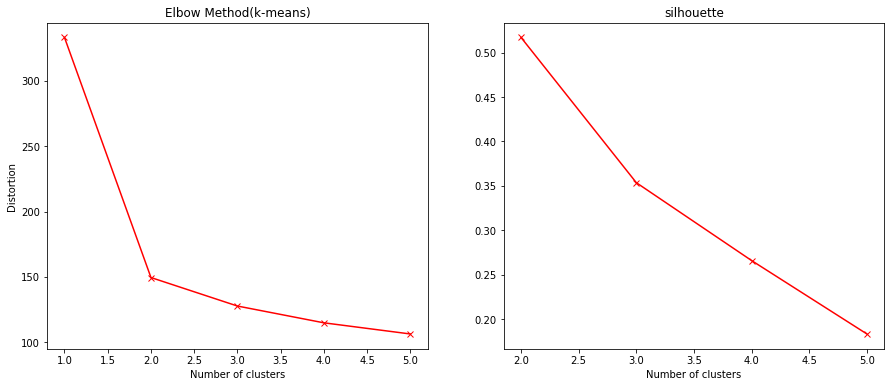

In [ ]:
best_k , bb = k_mean (1,6,df)

In [ ]:
kmeanModel = KMeans(n_clusters=2, random_state = 0)
kmean_pre = kmeanModel.fit_predict(df)

In [ ]:
tfs_embedded = TSNE(n_components=2, perplexity=50, verbose=2 , random_state=1 , n_iter=2000).fit_transform(df)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 768 samples in 0.001s...
[t-SNE] Computed neighbors for 768 samples in 0.031s...
[t-SNE] Computed conditional probabilities for sample 768 / 768
[t-SNE] Mean sigma: 0.162549
[t-SNE] Computed conditional probabilities in 0.072s
[t-SNE] Iteration 50: error = 56.6365242, gradient norm = 0.3734219 (50 iterations in 0.358s)
[t-SNE] Iteration 100: error = 56.6985245, gradient norm = 0.3527383 (50 iterations in 0.372s)
[t-SNE] Iteration 150: error = 56.1783676, gradient norm = 0.3660860 (50 iterations in 0.354s)
[t-SNE] Iteration 200: error = 55.9248962, gradient norm = 0.3682066 (50 iterations in 0.347s)
[t-SNE] Iteration 250: error = 56.6827698, gradient norm = 0.3422031 (50 iterations in 0.364s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.682770
[t-SNE] Iteration 300: error = 0.8023795, gradient norm = 0.0012814 (50 iterations in 0.286s)
[t-SNE] Iteration 350: error = 0.7503587, gradient norm = 0.0003148 

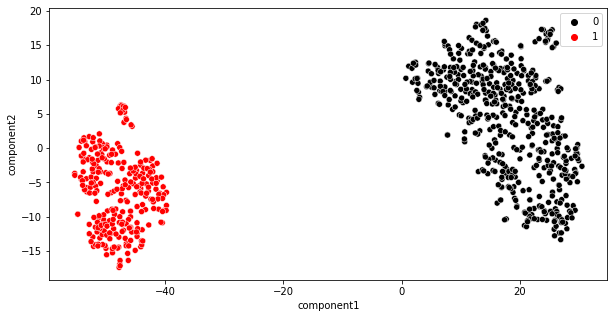

In [ ]:
plt.figure(figsize=(10,5))
sns.scatterplot(x=tfs_embedded[:, 0], y=tfs_embedded[:, 1], hue = kmean_pre ,palette = ['black','red'], legend='full' )
plt.xlabel("component1")
plt.ylabel("component2")
plt.show()

## **PCA**

In [ ]:
from sklearn.decomposition import PCA
max_n_lr = 0
max_n_knn = 0
lrl = []
knnl = []
for i in range(1,9):
  pca = PCA(n_components=i)
  trans_tarin = pca.fit_transform(X_train)
  trans_test = pca.transform(X_test)

  #LR model
  lr.fit(trans_tarin, y_train)
  lr_pred = lr.predict(trans_test)
  lr_accy = accuracy_score(y_test, lr_pred)
  lrl.append(lr_accy)
  if max_n_lr < lr_accy:
        max_n_lr = lr_accy 
        best_n_lr = i

  #KNN model
  neigh.fit(trans_tarin, y_train)
  neigh_pred = neigh.predict(trans_test)
  neigh_accy = accuracy_score(y_test, neigh_pred)
  knnl.append(neigh_accy)
  if max_n_knn < neigh_accy:
        max_n_knn = neigh_accy 
        best_n_knn = i

In [ ]:
dic = {
    'N': [1,2,3,4,5,6,7,8],
    'Accuracies-LR' : lrl,
    'Accuracies-KNN': knnl 
    }

accuracies = pd.DataFrame.from_dict(dic)

In [ ]:
accuracies

,N,Accuracies-LR,Accuracies-KNN
0,1,0.708333,0.671875
1,2,0.708333,0.651042
2,3,0.760417,0.729167
3,4,0.760417,0.760417
4,5,0.760417,0.708333
5,6,0.755208,0.708333
6,7,0.786458,0.760417
7,8,0.770833,0.750000


Best value of n-components: 7


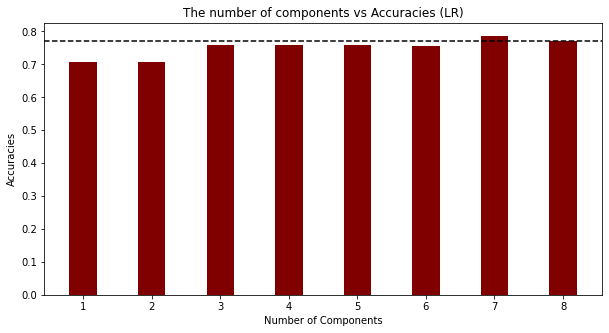

In [ ]:
print('Best value of n-components: {}'.format(best_n_lr))
plt.figure(figsize=(10,5))
plt.bar(accuracies['N'], accuracies['Accuracies-LR'], color ='maroon', width = 0.4)
plt.axhline(y= lr_acc, color='k', linestyle='--', label = 'Baseline')
plt.xlabel("Number of Components")
plt.ylabel("Accuracies")
plt.title("The number of components vs Accuracies (LR)")
plt.show()

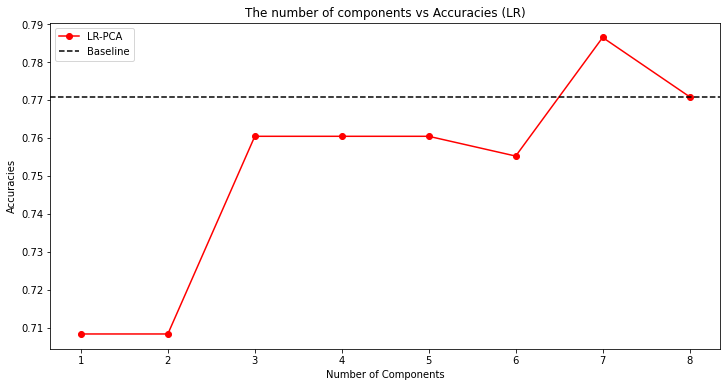

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

xi = np.arange(1, 9)
f = lrl

# plt.ylim(0,1)
plt.plot(xi, f, marker='o', linestyle='-', color='r', label = 'LR-PCA')
plt.axhline(y= lr_acc, color='k', linestyle='--', label = 'Baseline')

plt.xlabel('Number of Components')
plt.ylabel('Accuracies')
plt.title('The number of components vs Accuracies (LR)')
plt.legend()
plt.show()

Best value of n-components: 4


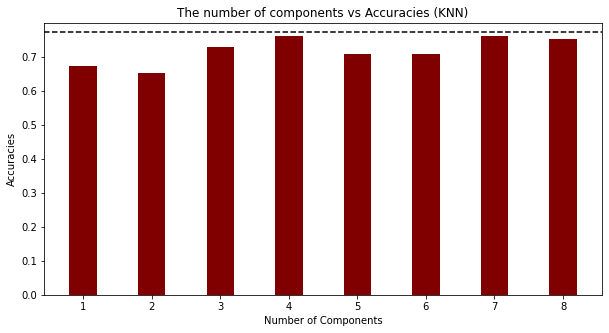

In [ ]:
print('Best value of n-components: {}'.format(best_n_knn))
plt.figure(figsize=(10,5))
plt.bar(accuracies['N'], accuracies['Accuracies-KNN'], color ='maroon', width = 0.4)
plt.axhline(y= lr_acc, color='k', linestyle='--', label = 'Baseline')
plt.xlabel("Number of Components")
plt.ylabel("Accuracies")
plt.title("The number of components vs Accuracies (KNN)")
plt.show()

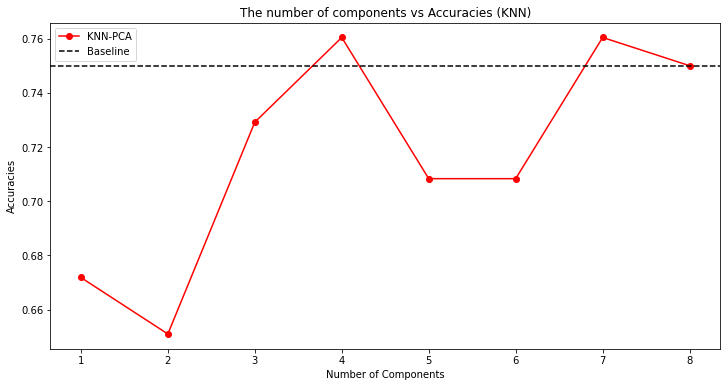

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

xi = np.arange(1, 9)
f = knnl

# plt.ylim(0,1)
plt.plot(xi, f, marker='o', linestyle='-', color='r', label = 'KNN-PCA')
plt.axhline(y= neigh_acc, color='k', linestyle='--', label = 'Baseline')

plt.xlabel('Number of Components')
plt.ylabel('Accuracies')
plt.title('The number of components vs Accuracies (KNN)')
plt.legend()
plt.show()

In [ ]:
# The number of components vs Accuracies (LR)
pca = PCA(n_components=7)
trans_tarin_lr = pca.fit_transform(X_train)
trans_test_lr = pca.transform(X_test)

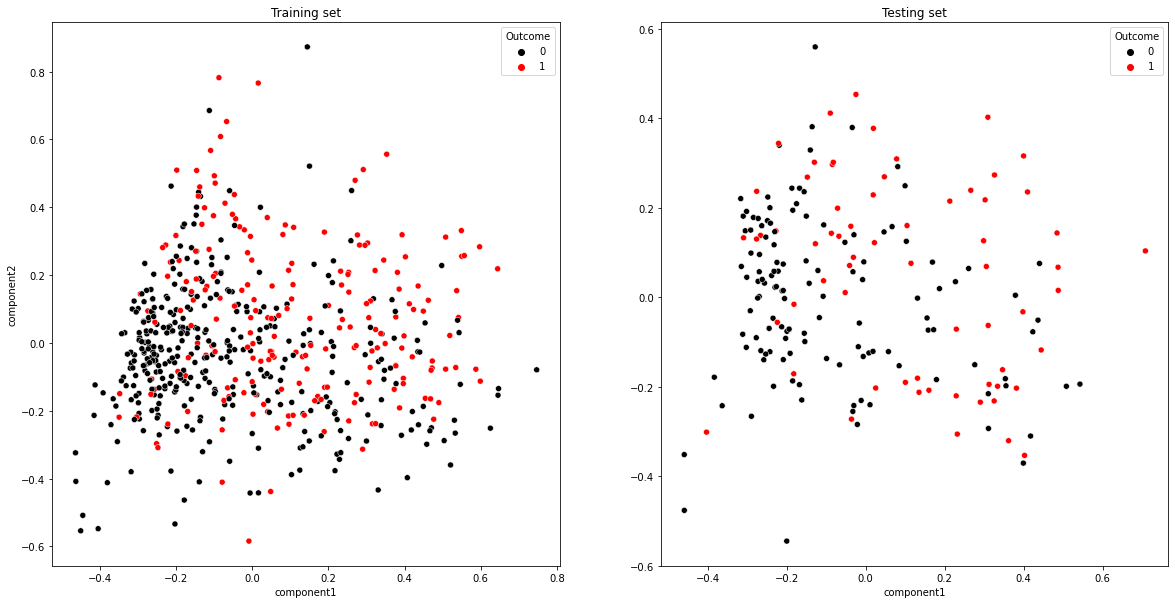

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
axes[0].set_title('Training set')
axes[1].set_title('Testing set')
sns.scatterplot(ax=axes[0],x=trans_tarin_lr[:, 0], y=trans_tarin_lr[:, 1],hue = y_train,palette = ['black','red'], legend='full' )
sns.scatterplot(ax=axes[1],x=trans_test_lr[:, 0], y=trans_test_lr[:, 1],hue = y_test,palette = ['black','red'], legend='full')
axes[0].set(xlabel='component1', ylabel='component2')
axes[1].set(xlabel='component1')
plt.show()

In [ ]:
# The number of components vs Accuracies (KNN)
pca = PCA(n_components=4)
trans_tarin_knn = pca.fit_transform(X_train)
trans_test_knn = pca.transform(X_test)

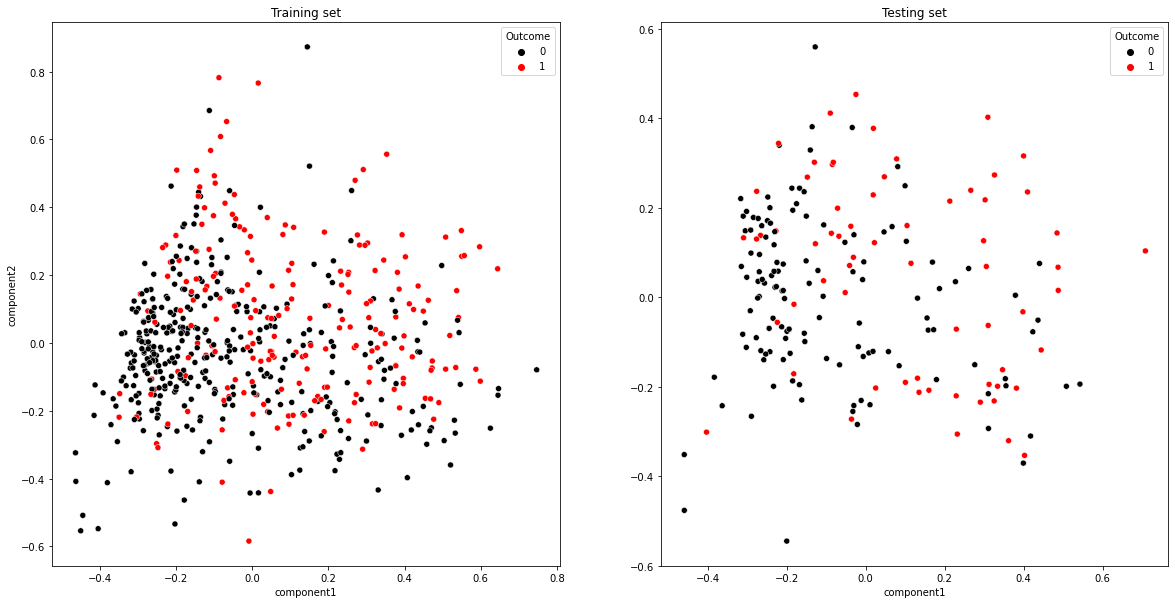

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
axes[0].set_title('Training set')
axes[1].set_title('Testing set')

sns.scatterplot(ax=axes[0],x=trans_tarin_knn[:, 0], y=trans_tarin_knn[:, 1],hue = y_train,palette = ['black','red'], legend='full' )
sns.scatterplot(ax=axes[1],x=trans_test_knn[:, 0], y=trans_test_knn[:, 1],hue = y_test,palette = ['black','red'], legend='full')
axes[0].set(xlabel='component1', ylabel='component2')
axes[1].set(xlabel='component1')
plt.show()

## **Feature selection**


filter method

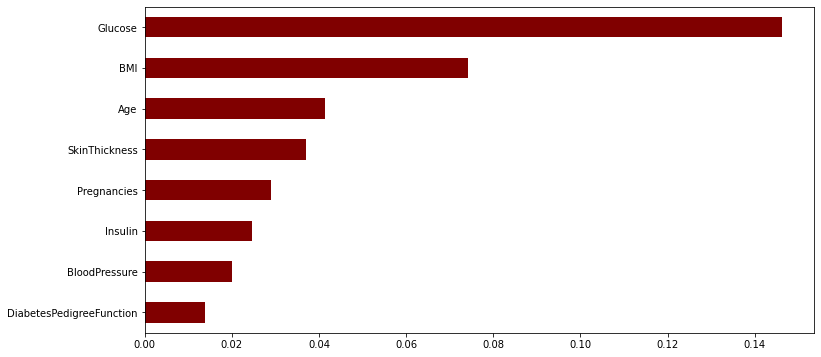

In [ ]:
importance = mutual_info_classif(x,y,random_state = 0)
feat_importance = pd.Series(importance,x.columns[0:len(x.columns)])
feat_importance = feat_importance.sort_values(ascending=True)
feat_importance.plot(kind='barh', color = 'maroon')

LR

Maximum accuracy: 78.64583333333334
Best number of features: 3


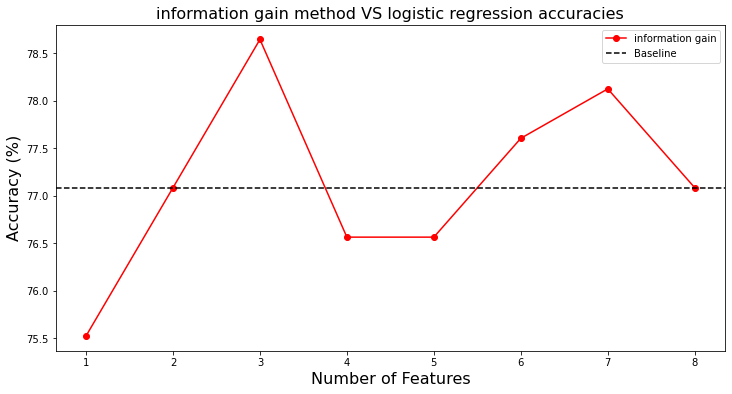

In [ ]:
model = lr
acc_dict = {}
for i in range(1,9):
  fsm =  SelectKBest(mutual_info_classif, k=i)
  acc, _, _ = select_feature(X_train, y_train, X_test, y_test, fsm, model)
  acc_dict[i] = acc

plt.plot(*zip(*sorted(acc_dict.items())),marker='o', linestyle='-', color='r', label = 'information gain')
plt.axhline(lr_acc*100, color='k', linestyle='--', label = 'Baseline')
plt.title("information gain method VS logistic regression accuracies", fontsize=16)
plt.xlabel("Number of Features", fontsize=16)
plt.ylabel("Accuracy (%)", fontsize=16)


print("Maximum accuracy:", max(acc_dict.values()))
print("Best number of features:", max(acc_dict, key=acc_dict.get))

plt.legend()
plt.show()

KNN

Maximum accuracy: 78.125
Best number of features: 4


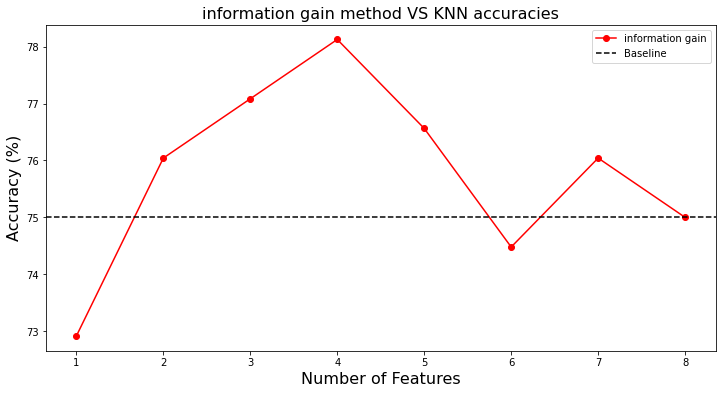

In [ ]:
model = neigh
acc_dict = {}
for i in range(1,9):
  fsm =  SelectKBest(mutual_info_classif, k=i)
  acc, _, _ = select_feature(X_train, y_train, X_test, y_test, fsm, model)
  acc_dict[i] = acc

plt.plot(*zip(*sorted(acc_dict.items())),marker='o', linestyle='-', color='r', label = 'information gain' )
plt.axhline(neigh_acc*100, color='k', linestyle='--', label = 'Baseline')
plt.title("information gain method VS KNN accuracies", fontsize=16)
plt.xlabel("Number of Features", fontsize=16)
plt.ylabel("Accuracy (%)", fontsize=16)


print("Maximum accuracy:", max(acc_dict.values()))
print("Best number of features:", max(acc_dict, key=acc_dict.get))

plt.legend()
plt.show()

**wrapper method [backward feature selection]**

**LR**

Best number of features: 6
Best accurcy : 0.796875


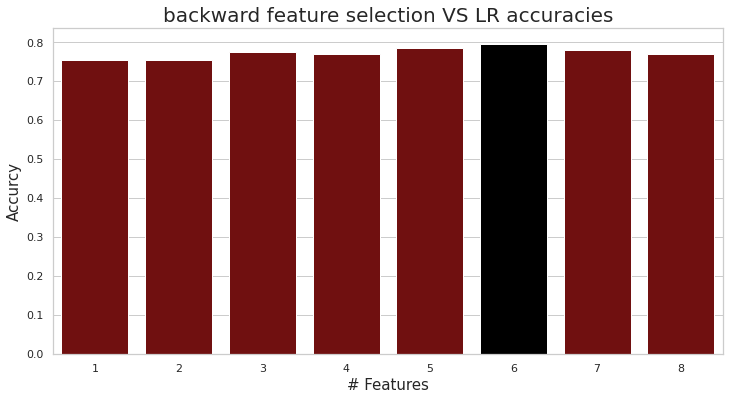

In [ ]:
accur_lr_bw = wrapper(1,8,LogisticRegression(random_state=0),lr_acc,'backward', X_train,y_train,X_test,y_test)
features_accurcy(accur_lr_bw , "backward feature selection VS LR accuracies",1,9)

**KNN**

Best number of features: 4
Best accurcy : 0.7604166666666666


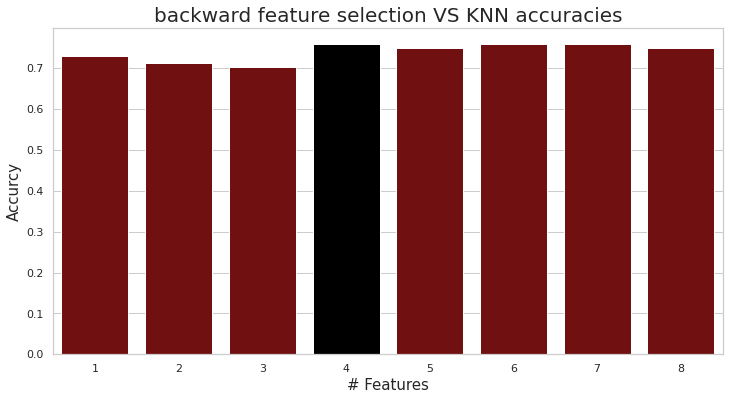

In [ ]:
accur_knn_bw = wrapper(1,8,KNeighborsClassifier(),neigh_acc,'backward', X_train,y_train,X_test,y_test)
features_accurcy(accur_knn_bw , "backward feature selection VS KNN accuracies",1,9)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 576 samples in 0.001s...
[t-SNE] Computed neighbors for 576 samples in 0.021s...
[t-SNE] Computed conditional probabilities for sample 576 / 576
[t-SNE] Mean sigma: 0.128313
[t-SNE] Computed conditional probabilities in 0.049s
[t-SNE] Iteration 50: error = 60.6072960, gradient norm = 0.4672696 (50 iterations in 0.263s)
[t-SNE] Iteration 100: error = 61.5735855, gradient norm = 0.4568194 (50 iterations in 0.290s)
[t-SNE] Iteration 150: error = 61.6507187, gradient norm = 0.4635159 (50 iterations in 0.260s)
[t-SNE] Iteration 200: error = 61.8564873, gradient norm = 0.4675750 (50 iterations in 0.291s)
[t-SNE] Iteration 250: error = 62.1263199, gradient norm = 0.4630073 (50 iterations in 0.282s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.126320
[t-SNE] Iteration 300: error = 0.9436963, gradient norm = 0.0020195 (50 iterations in 0.213s)
[t-SNE] Iteration 350: error = 0.9064467, gradient norm = 0.0004928 

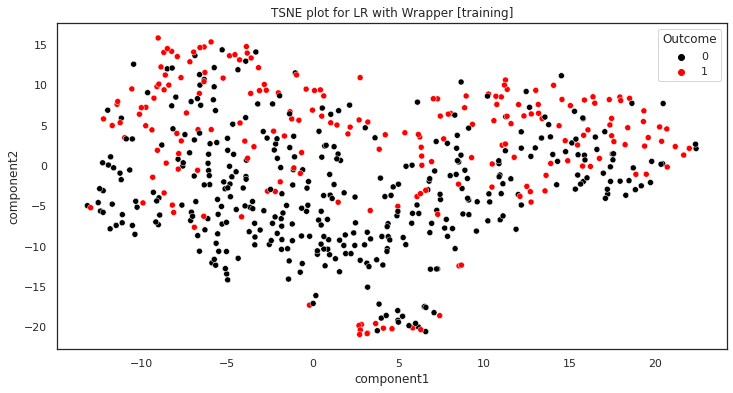

In [ ]:
sfs=SequentialFeatureSelector(estimator=LogisticRegression(random_state=0),n_features_to_select=6, direction='backward')
X_train_new=sfs.fit_transform(X_train,y_train)
X_test_new=sfs.transform(X_test)

#c)TSNE plot for LR with gain information
LR_Var = LogisticRegression().fit(X_train_new,y_train)
y_pred_var = LR_Var.predict(X_test_new)
Visulaize_Data(X_train_new,y_train,'TSNE plot for LR with Wrapper [training]')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 192 samples in 0.000s...
[t-SNE] Computed neighbors for 192 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 192 / 192
[t-SNE] Mean sigma: 0.173982
[t-SNE] Computed conditional probabilities in 0.029s
[t-SNE] Iteration 50: error = 55.3430481, gradient norm = 0.4956855 (50 iterations in 0.105s)
[t-SNE] Iteration 100: error = 55.2096825, gradient norm = 0.4755465 (50 iterations in 0.076s)
[t-SNE] Iteration 150: error = 55.6648178, gradient norm = 0.5431903 (50 iterations in 0.068s)
[t-SNE] Iteration 200: error = 56.1430893, gradient norm = 0.5046379 (50 iterations in 0.071s)
[t-SNE] Iteration 250: error = 56.0169373, gradient norm = 0.5256267 (50 iterations in 0.074s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.016937
[t-SNE] Iteration 300: error = 0.6358442, gradient norm = 0.0048164 (50 iterations in 0.064s)
[t-SNE] Iteration 350: error = 0.4502820, gradient norm = 0.0055459 

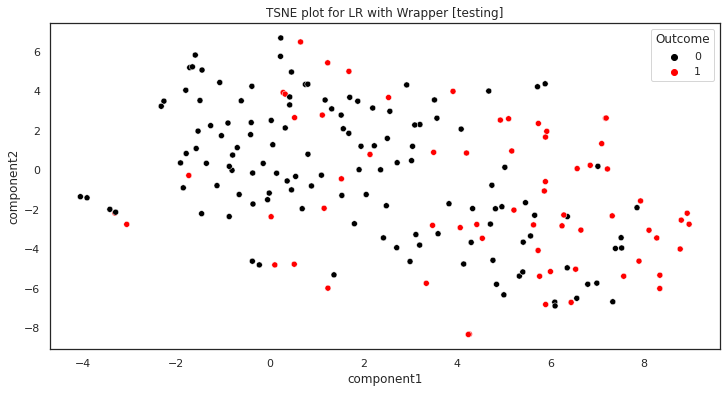

In [ ]:
Visulaize_Data(X_test_new,y_test,'TSNE plot for LR with Wrapper [testing]')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 576 samples in 0.000s...
[t-SNE] Computed neighbors for 576 samples in 0.017s...
[t-SNE] Computed conditional probabilities for sample 576 / 576
[t-SNE] Mean sigma: 0.077262
[t-SNE] Computed conditional probabilities in 0.051s
[t-SNE] Iteration 50: error = 57.9752579, gradient norm = 0.4544513 (50 iterations in 0.257s)
[t-SNE] Iteration 100: error = 58.1872330, gradient norm = 0.4613581 (50 iterations in 0.242s)
[t-SNE] Iteration 150: error = 58.4656754, gradient norm = 0.4568200 (50 iterations in 0.254s)
[t-SNE] Iteration 200: error = 58.0786514, gradient norm = 0.4493128 (50 iterations in 0.270s)
[t-SNE] Iteration 250: error = 59.1953125, gradient norm = 0.4524188 (50 iterations in 0.256s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.195312
[t-SNE] Iteration 300: error = 0.6389089, gradient norm = 0.0017837 (50 iterations in 0.208s)
[t-SNE] Iteration 350: error = 0.5860159, gradient norm = 0.0018414 

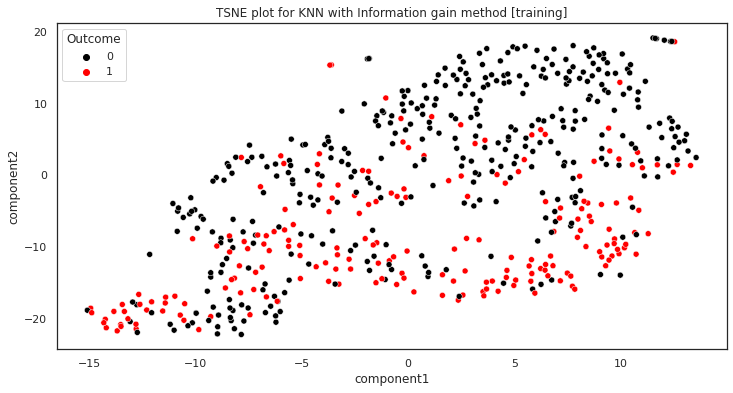

In [ ]:
f =  SelectKBest(mutual_info_classif, k=3)
X_train_newk = f.fit_transform(X_train,y_train)
X_test_newk = f.transform(X_test) 

knn_ = KNeighborsClassifier(n_neighbors= 5).fit(X_train_newk,y_train)
y_pred_knn = knn_.predict(X_test_newk)
Visulaize_Data(X_train_newk,y_train,'TSNE plot for KNN with Information gain method [training]')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 192 samples in 0.000s...
[t-SNE] Computed neighbors for 192 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 192 / 192
[t-SNE] Mean sigma: 0.119930
[t-SNE] Computed conditional probabilities in 0.029s
[t-SNE] Iteration 50: error = 54.7618103, gradient norm = 0.5234697 (50 iterations in 0.108s)
[t-SNE] Iteration 100: error = 55.6742477, gradient norm = 0.4865529 (50 iterations in 0.079s)
[t-SNE] Iteration 150: error = 55.0456543, gradient norm = 0.4918121 (50 iterations in 0.077s)
[t-SNE] Iteration 200: error = 55.2377853, gradient norm = 0.4829533 (50 iterations in 0.067s)
[t-SNE] Iteration 250: error = 54.1955414, gradient norm = 0.5366875 (50 iterations in 0.079s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.195541
[t-SNE] Iteration 300: error = 0.4017695, gradient norm = 0.0039440 (50 iterations in 0.062s)
[t-SNE] Iteration 350: error = 0.3126150, gradient norm = 0.0032583 

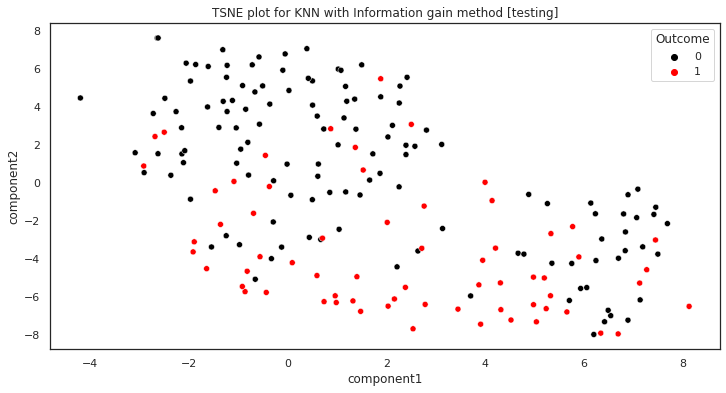

In [ ]:
Visulaize_Data(X_test_newk,y_test,'TSNE plot for KNN with Information gain method [testing]')

## **Best number of cluster for k-means clustering algorithm**

optimal number of clusters is : 2 clusters
Silhouetter Score: 0.252


(2, 0.25175370925612967)

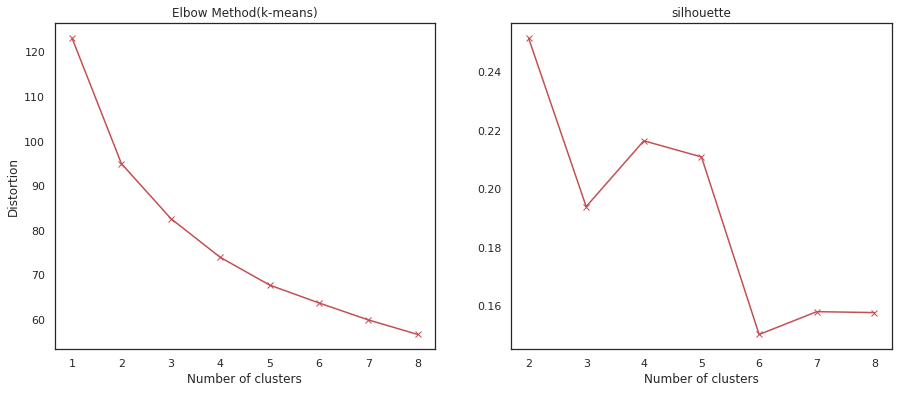

In [ ]:
k_mean(1,9,trans_tarin)

## **SOM algorithm**

**SOM with LR**

In [ ]:
pca = PCA(n_components=7)
data_lr= pca.fit_transform(x)

Optimal number of neurons is : 2
The silhouette score is : 0.24504240257135304


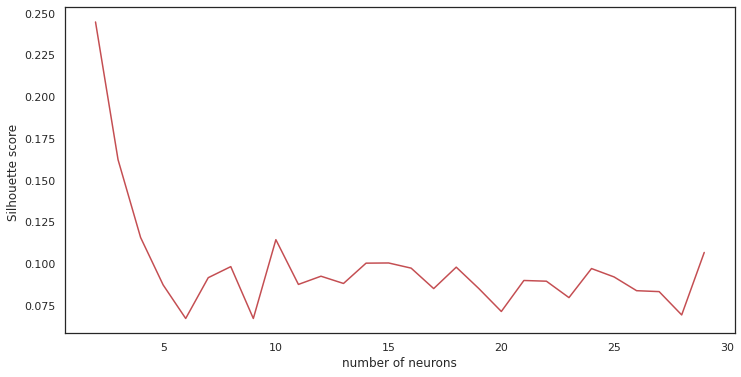

In [ ]:
som_lr=Sooom(data_lr)

In [ ]:
som_shape = (2, 1)
som = MiniSom(som_shape[0],som_shape[1], data_lr.shape[1], random_seed=0)
intial_lr = np.array(som.get_weights()) #before training
som.train_batch(data_lr,5000, verbose=True)
final_lr = np.array(som.get_weights()) # after training 

winner_coordinates = np.array([som.winner(x) for x in data_lr]).T
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

/usr/local/lib/python3.7/dist-packages/minisom.py:160: UserWarning: Warning: sigma is too high for the dimension of the map.
  warn('Warning: sigma is too high for the dimension of the map.')


 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 0.3726585246306014


In [ ]:
intial_lr = intial_lr.reshape(2,7)
final_lr = final_lr.reshape(2,7)

In [ ]:
intial_lr

array([[ 0.16069505,  0.70840777,  0.33829913,  0.14775635, -0.25132995,
         0.48028639, -0.20546417],
       [ 0.48453665,  0.57344839, -0.14415709,  0.36079942,  0.03573663,
         0.08415609,  0.52636901]])

In [ ]:
final_lr

array([[-0.1145619 , -0.01293325,  0.04552792,  0.06957701,  0.05327652,
        -0.03641835, -0.00596464],
       [ 0.28099089, -0.06432619,  0.01338899,  0.02521026, -0.00143941,
         0.02246545, -0.0316907 ]])

**plotting states of neurons with LR**

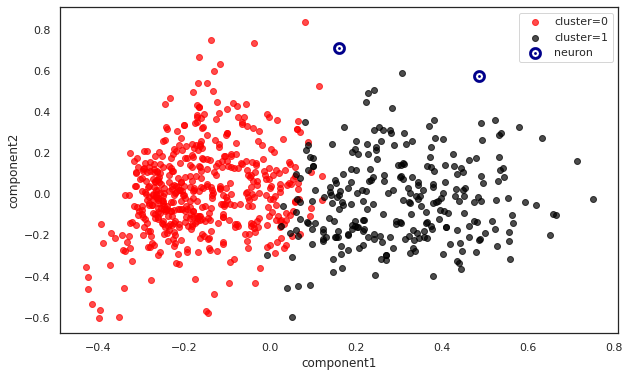

In [ ]:
#plot the intial state of neurons in som with LR dimensions
plot_state(intial_lr,data_lr)

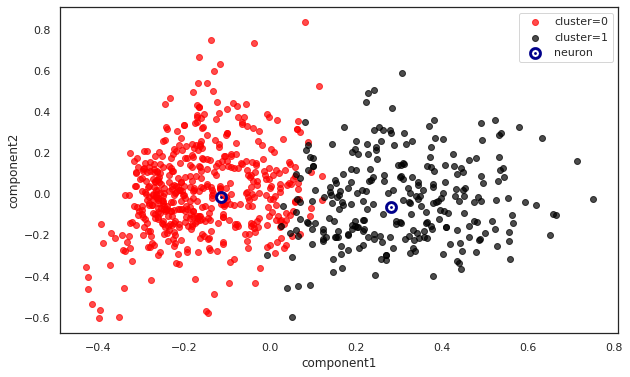

In [ ]:
#plot the final state of neurons in som with LR dimensions
plot_state(final_lr,data_lr)

## **DBSCAN**

In [ ]:
epsList, msList, accList, clusters = list(), list(), list(),list()
for eps in tqdm(np.arange(0.3, 0.7, 0.1)):
  for ms in range(2, 15):
    model = DBSCAN(eps=eps, min_samples=ms)
    predLabels = model.fit_predict(x)
    score = silhouette_score(x, predLabels, random_state=0)
    epsList.append(eps)
    msList.append(ms)
    accList.append(score)
    clusters.append(len(unique_labels(predLabels)))
epsList, msList, accList,clusters = np.array(epsList), np.array(msList), np.array(accList),np.array(clusters)

100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


In [ ]:
dicw = {
    'epsilon':epsList,
    'minpoints':msList,
    'silhouette':accList,
    'clusters_num' :clusters
}
DBSCAN_clusters = pd.DataFrame.from_dict(dicw)
DBSCAN_clusters = DBSCAN_clusters.sort_values(by="silhouette",ascending=False)

In [ ]:
DBSCAN_clusters.head()

,epsilon,minpoints,silhouette,clusters_num
51,0.6,14,0.485008,2
46,0.6,9,0.485008,2
29,0.5,5,0.485008,2
30,0.5,6,0.485008,2
31,0.5,7,0.485008,2


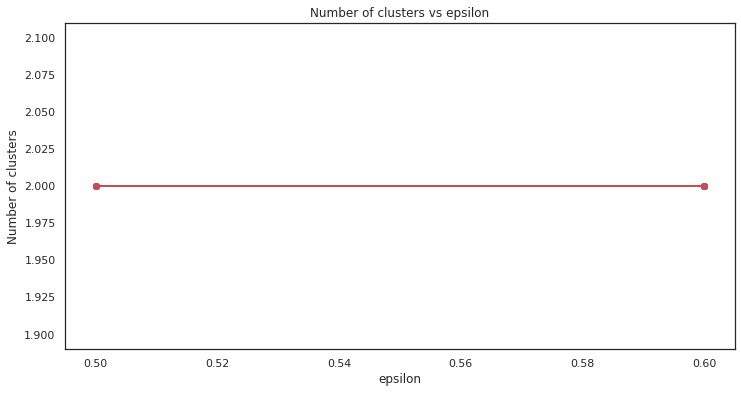

In [ ]:
plt.plot(DBSCAN_clusters['epsilon'].iloc[0:10], DBSCAN_clusters['clusters_num'].iloc[0:10],marker='o', linestyle='-', color='r')
plt.xlabel('epsilon')
plt.ylabel('Number of clusters')
plt.title('Number of clusters vs epsilon')
plt.show()

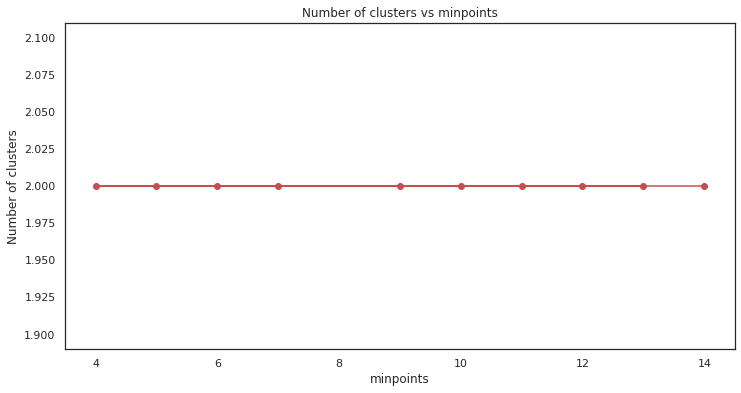

In [ ]:
plt.plot(DBSCAN_clusters['minpoints'].iloc[0:10], DBSCAN_clusters['clusters_num'].iloc[0:10],marker='o', linestyle='-', color='r')
plt.xlabel('minpoints')
plt.ylabel('Number of clusters')
plt.title('Number of clusters vs minpoints')
plt.show()